# Node Classification with DGL

This notebooks adopts [the tutorial in DGL](https://docs.dgl.ai/en/0.4.x/tutorials/models/1_gnn/9_gat.html). 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



import os
import sys
import time

In [2]:
if 'google.colab' in sys.modules:
    !pip install dgl-cu101 

In [5]:
# Import libs
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

os.environ['DGLBACKEND'] = 'pytorch'  # tell DGL what backend to use
import dgl
from dgl import DGLGraph
from dgl.data import MiniGCDataset

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from dgl import DGLGraph
from dgl.data import citation_graph as citegrh
import networkx as nx

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

## Download node classification graph

[Cora dataset](https://docs.dgl.ai/en/0.4.x/api/python/data.html#dgl.data.CoraDataset) is a popular citation network, where nodes are papers and edges are citation relationships. 
Node features are bag of words of topics appearing in each paper. Each node has a target label, which is the category of a paper. 

It's used often as a benchmark dataset in semi-supervised node classification, i.e. we are given access to the whole graph and node features, but train our model only small subset of nodes  (140 out 2708 nodes). We then apply our trained model on the same graph but different subset of nodes' target labels. 

In [73]:
def load_cora_data():
    data = citegrh.load_cora()
    features = torch.FloatTensor(data.features)
    labels = torch.LongTensor(data.labels)
    train_mask = torch.BoolTensor(data.train_mask)
    val_mask = torch.BoolTensor(data.val_mask)
    test_mask = torch.BoolTensor(data.test_mask)
    g = DGLGraph(data.graph)
    
    return g, features, labels, train_mask, val_mask, test_mask

# get graph, features, labels, and masks
g, features, labels, train_mask, val_mask, test_mask = load_cora_data()

Loading from cache failed, re-processing.
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


## Define GAT model

GAT introduces the attention mechanism as a substitute for the statically normalized convolution operation. Below are the equations to compute the node embedding $h^{(l+1)}_i$ of layer $l+1$ from the embeddings of layer $l$.

<img src="https://data.dgl.ai/tutorial/gat/gat.png" width="500" height="600">
<!-- ![a](https://data.dgl.ai/tutorial/gat/gat.png) -->

\begin{split}\begin{align}
z_i^{(l)}&=W^{(l)}h_i^{(l)},&(1) \\
e_{ij}^{(l)}&=\text{LeakyReLU}(\vec a^{(l)^T}(z_i^{(l)}||z_j^{(l)})),&(2)\\
\alpha_{ij}^{(l)}&=\frac{\exp(e_{ij}^{(l)})}{\sum_{k\in \mathcal{N}(i)}^{}\exp(e_{ik}^{(l)})},&(3)\\
h_i^{(l+1)}&=\sigma\left(\sum_{j\in \mathcal{N}(i)} {\alpha^{(l)}_{ij} z^{(l)}_j }\right),&(4)
\end{align}\end{split}

<p>Explanations:</p>
<ul class="simple">
<li>Equation (1) is a linear transformation of the lower layer embedding <span class="math notranslate nohighlight">\(h_i^{(l)}\)</span>
and <span class="math notranslate nohighlight">\(W^{(l)}\)</span> is its learnable weight matrix.</li>
<li>Equation (2) computes a pair-wise <em>un-normalized</em> attention score between two neighbors.
Here, it first concatenates the <span class="math notranslate nohighlight">\(z\)</span> embeddings of the two nodes, where <span class="math notranslate nohighlight">\(||\)</span>
denotes concatenation, then takes a dot product of it and a learnable weight vector
<span class="math notranslate nohighlight">\(\vec a^{(l)}\)</span>, and applies a LeakyReLU in the end. This form of attention is
usually called <em>additive attention</em>, contrast with the dot-product attention in the
Transformer model.</li>
<li>Equation (3) applies a softmax to normalize the attention scores on each node’s
incoming edges.</li>
<li>Equation (4) is similar to GCN. The embeddings from neighbors are aggregated together,
scaled by the attention scores.</li>
</ul>
</div>

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

In [40]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

In [35]:
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

## Define training pipeline

Now that we have a GNN model, we need to train and evaluate it. 

### Exercise 1.1:
<p>Instructions:</p>
<ol class="simple">
<li>Define a GAT model with 8 heads of hidden dimension 8.</li>
   
<li>Define Adam optimizer with GNN parameters.</li>
<li>Compute a loss (cross entropy in classification) and accuracy of the model on training nodes.</li>
<li>Evaluate the model on test nodes.</li>
</ol>

In [70]:
import time
import numpy as np

# if you have gpu, move tensors and models there
g = g.to('cuda')
features = features.cuda()
labels = labels.cuda()

# define a GAT model with hidden_dim=8 and heads=8
net = GAT(...)

# create optimizer Adam (https://pytorch.org/docs/stable/optim.html)
optimizer = ...

def evaluate(net, labels, features, mask):
    net.eval()
    y = labels[mask]
    logits = net(features)
    with torch.no_grad():
        pred = logits[mask]
        loss = F.cross_entropy(pred, y.long())
        acc = torch.Tensor([(y == pred.max(1)[1]).sum().item()/y.shape[0]])

        return loss, acc

# main loop
xs = list(range(30))
ys = []
for epoch in xs:
    start2epoch = time.time()

    net.train()
    logits = net(features)
    train_loss = ...
    train_acc = ...
    

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    test_loss, test_acc = evaluate(net, labels, features, test_mask)
    
    ys.append([train_loss, test_loss, train_acc, test_acc])
    

    print("Epoch {:05d} | Train Loss {:.3f} | Test Loss {:.3f} | Train Acc {:.2f} | Test Acc {:.2f} | Time(s) {:.2f}".format(
        epoch, train_loss.item(), test_loss.item(), train_acc.item(), test_acc.item(), time.time() - start2epoch))

Epoch 00000 | Train Loss 1.945 | Test Loss 1.921 | Train Acc 0.18 | Test Acc 0.63 | Time(s) 0.52
Epoch 00001 | Train Loss 1.900 | Test Loss 1.897 | Train Acc 0.90 | Test Acc 0.70 | Time(s) 0.51
Epoch 00002 | Train Loss 1.855 | Test Loss 1.871 | Train Acc 0.95 | Test Acc 0.71 | Time(s) 0.59
Epoch 00003 | Train Loss 1.807 | Test Loss 1.844 | Train Acc 0.96 | Test Acc 0.71 | Time(s) 0.52
Epoch 00004 | Train Loss 1.756 | Test Loss 1.816 | Train Acc 0.96 | Test Acc 0.72 | Time(s) 0.52
Epoch 00005 | Train Loss 1.704 | Test Loss 1.786 | Train Acc 0.96 | Test Acc 0.72 | Time(s) 0.51
Epoch 00006 | Train Loss 1.648 | Test Loss 1.754 | Train Acc 0.96 | Test Acc 0.73 | Time(s) 0.52
Epoch 00007 | Train Loss 1.590 | Test Loss 1.721 | Train Acc 0.96 | Test Acc 0.73 | Time(s) 0.52
Epoch 00008 | Train Loss 1.530 | Test Loss 1.686 | Train Acc 0.97 | Test Acc 0.73 | Time(s) 0.51
Epoch 00009 | Train Loss 1.467 | Test Loss 1.650 | Train Acc 0.98 | Test Acc 0.73 | Time(s) 0.51
Epoch 00010 | Train Loss 1.403

In [74]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

set_default(figsize=(3, 3), dpi=150)

def plot(xs, ys, legend, title, output_fn=None, logx=False, logy=False, ylabel='Accuracy'):
        y = list(zip(*ys))

        plt.rcParams.update({'font.size': 40})
        plt.rcParams["figure.figsize"] = (20, 10)
        lss = ['-', '--', '-.', ':']
        colors = ['#4053d3', '#ddb310', '#b51d14', '#00beff', '#fb49b0', '#00b25d', '#cacaca']
        colors = [(235, 172, 35), (184, 0, 88), (0, 140, 249), (0, 110, 0), (0, 187, 173), (209, 99, 230), (178, 69, 2),
                  (255, 146, 135), (89, 84, 214), (0, 198, 248), (135, 133, 0), (0, 167, 108), (189, 189, 189)]
        colors = [[p / 255 for p in c] for c in colors]
        for i in range(len(y)):
            plt.plot(xs, y[i], lw=4, color=colors[i])
        plt.legend(legend, loc=1, fontsize=30)
        plt.title(title)

        plt.xscale('log') if logx else None
        plt.yscale('log') if logy else None
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.grid()
        plt.tight_layout()

        plt.savefig(output_fn, bbox_inches='tight') if output_fn else None
        plt.show()

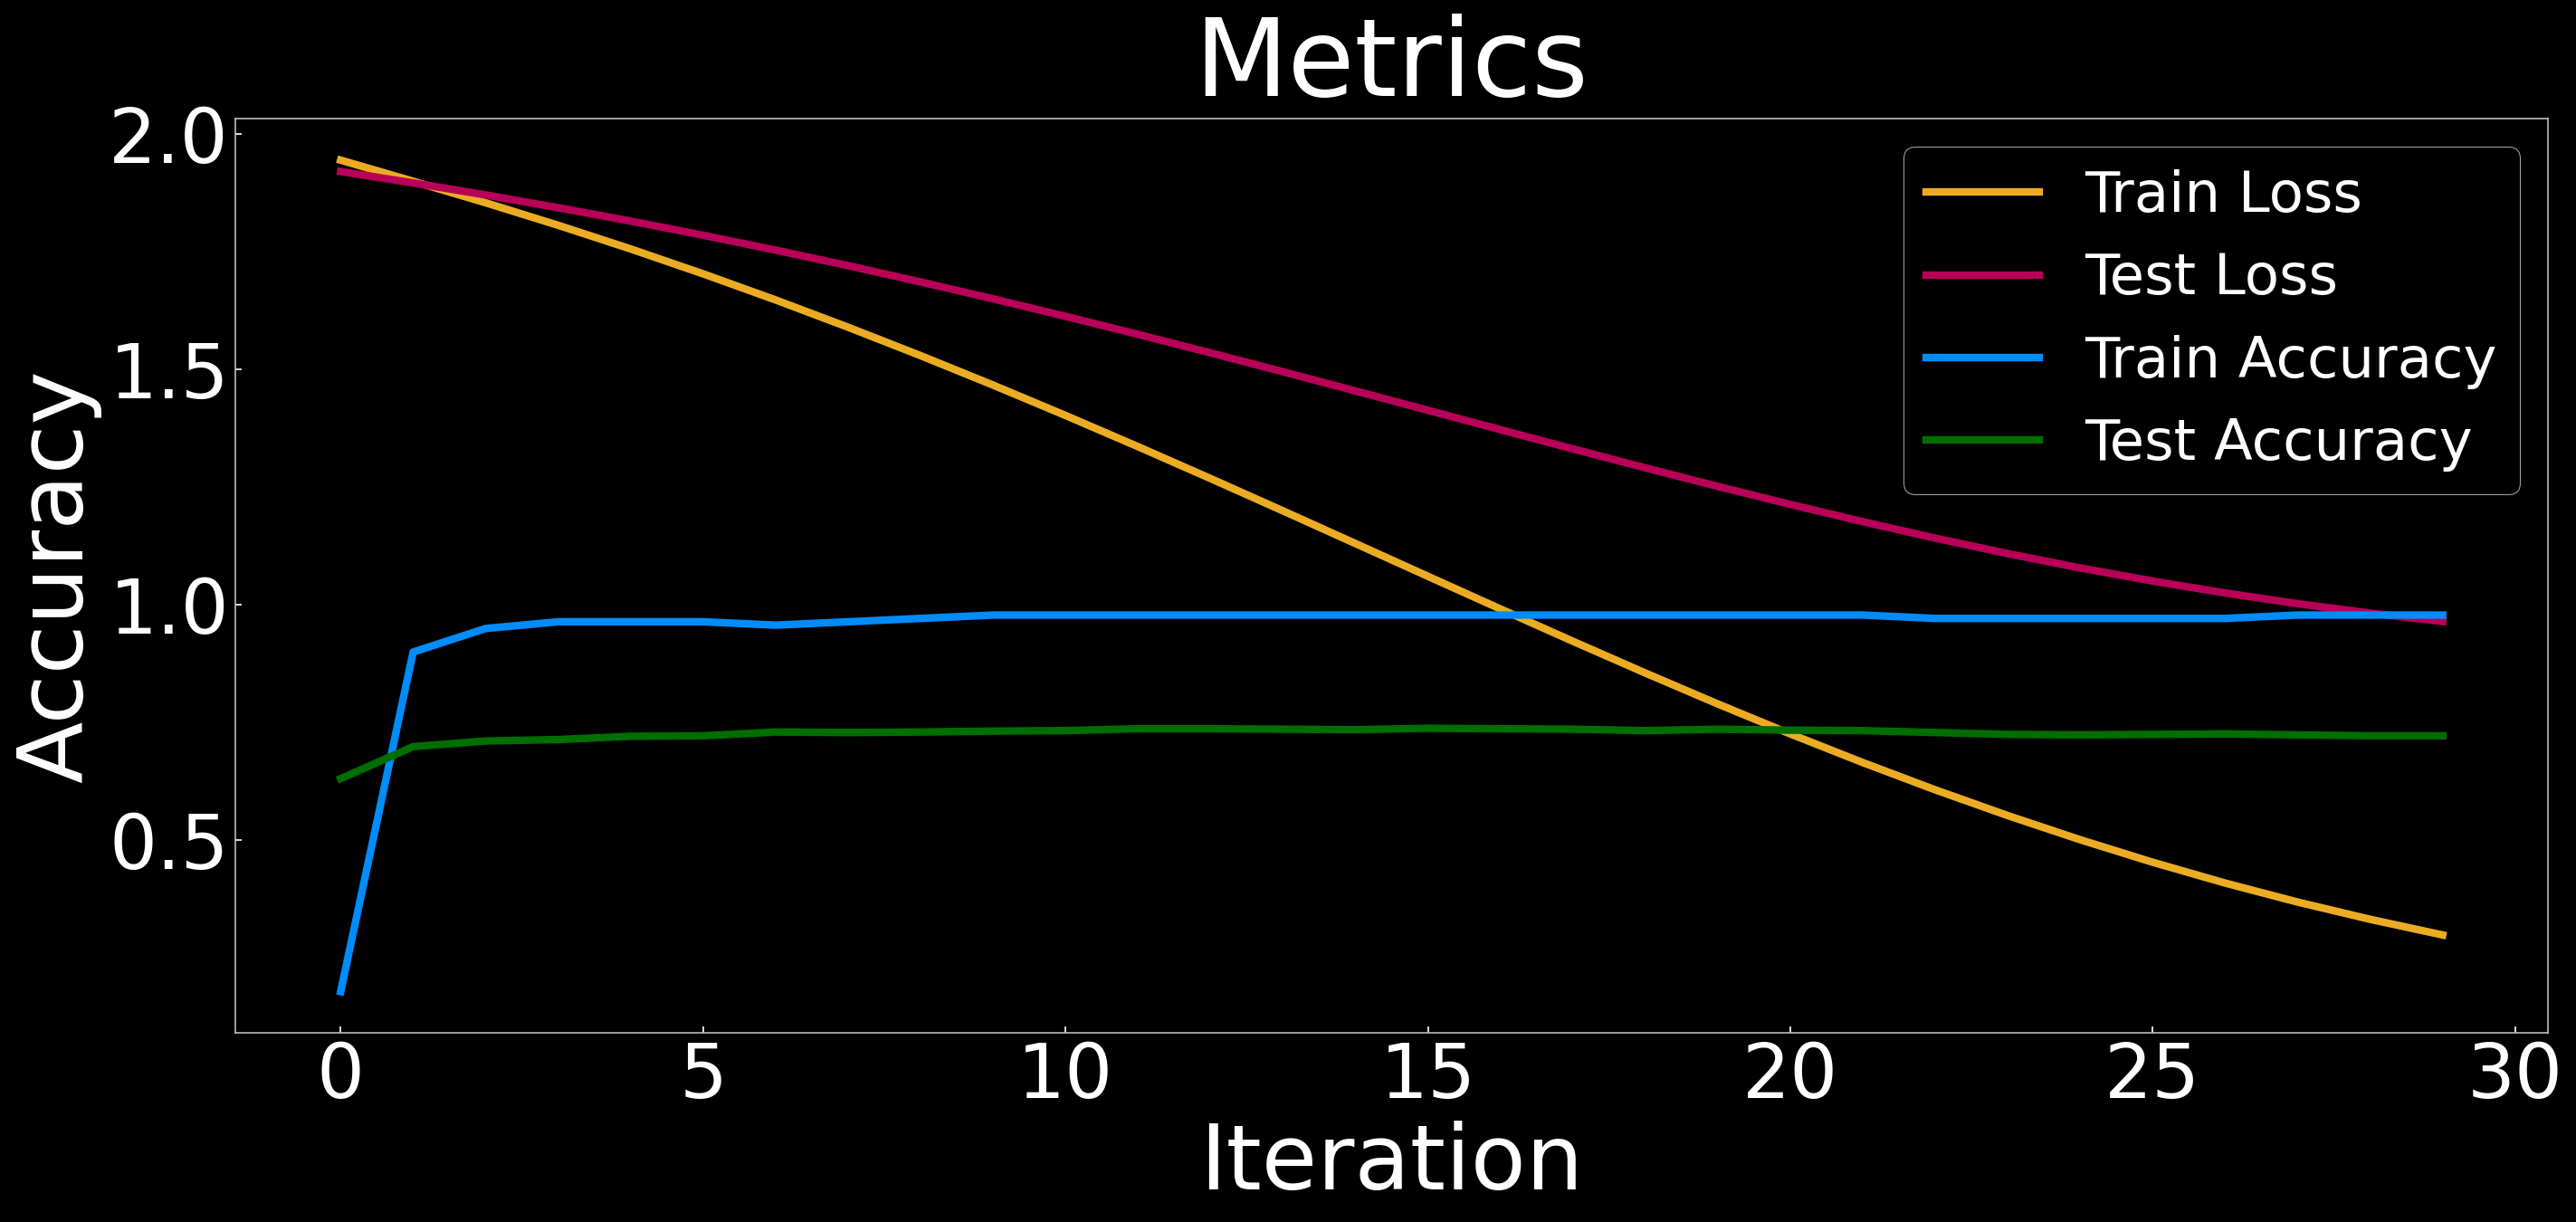

In [75]:
plot(xs, ys, legend=['Train Loss', 'Test Loss', 'Train Accuracy', 'Test Accuracy'], title='Metrics')

### Define optimized GNN models

Many GNN models are already implemented in DGL and are optimized. You can find the list of all [available GNN layers here](https://docs.dgl.ai/en/0.4.x/api/python/nn.pytorch.html). 

### Exercise 2.1

<p>Instructions:</p>
<ol>
<li>Import GatConv layer.</li>
   
<li>Create two layer GAT network with dropout and residual connection.</li>
<li>Run this model through the same pipeline.</li>
</ol>


<p>Questions:</p>
<ol>
<li>How much faster this GAT network runs compared to previously defined model?</li>
<li>What is the performance of the model?</li>
</ol>


### Exercise 2.2 (homework)
<p>Instructions:</p>
<ol>
<li>Try other GNN layers. For example, GraphConv, ChebConv, AGGNConv.</li>
   
<li>Create 2-layer GNN network with these layers.</li>
<li>Run this model through the same pipeline.</li>
</ol>


<p>Questions:</p>
<ol>
<li>What is the performance compared to GAT model in terms of running time and speed.</li>
</ol>

In [2]:
from dgl.nn.pytorch import GATConv as GATConvDGL, GraphConv, ChebConv as ChebConvDGL, AGNNConv as AGNNConvDGL, APPNPConv

import torch
from torch.nn import Dropout, ELU, Sequential, Linear, ReLU, Identity
import torch.nn.functional as F

class GNNModelDGL(torch.nn.Module):
    def __init__(self, graph, in_dim, hidden_dim, out_dim,
                 heads=8, dropout=0., name='gat', residual=True, use_mlp=False, join_with_mlp=False):
        super(GNNModelDGL, self).__init__()
        self.name = name
        self.graph = graph
        
        self.l1 = GATConvDGL(...) # https://pytorch.org/docs/stable/optim.html
        self.l2 = GATConvDGL(...)


    def forward(self, features):
        h = features
        graph = self.graph
        
        h = self.l1(graph, h).flatten(1)
        logits = self.l2(graph, h).mean(1)

        return logits

Using backend: pytorch


In [3]:
# Run through the same training pipeline as before

### YOUR CODE IS HERE ###

In [ ]:
plot(xs, ys, legend=['Train Loss', 'Test Loss', 'Train Accuracy', 'Test Accuracy'], title='GCN Metrics')